# Implementing feature selection

A more rigorous attempt at feature selection. 

We will try the following:

* Random forest decision tree aided feature selection using boruta_py
* Auto encode for feature compression



## Setting up everything

In [60]:
# Data processing
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

# Machine learning 
from sklearn.ensemble import RandomForestClassifier

# Evaluating Performance
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline

source_csv = '/home/work/GitHub/data/churn_prediction/usr_with_tch_complete.csv'

In [61]:
# Helper function

def prepare_time_series(df, month_array, type_operation, groupby_feature = 'user_id'):
    
    # If we want to append each month as a seperate feature 
    if type_operation == 'append':
        
        # Find the months of interest
        df_new = df[df.index.get_level_values(1).isin(month_array)].unstack().fillna(0)
        
        # Name new columns
        new_cols = [str(item[0]) + '_' + str(int(item[1])) for item in df_new.columns]
        
        # Drop level and rename
        df_new.columns = df_new.columns.droplevel(0)
        df_new.columns = new_cols
    
    # If we want to sum the values of each feature for every month
    elif type_operation == 'sum':
        df_new = df[df.index.get_level_values(1).isin(month_array)]
        df_new = df_new.reset_index().groupby(groupby_feature).sum()
    
    return df_new


In [62]:
# Reading the dataframe 
df = pd.read_csv(source_csv)

# Remove users who didn't have any activity in month 0
min_months = df.groupby('user_id')['event_leg'].min()
min_months = min_months[min_months == 0]

# Update the dataframe
df = df.set_index('user_id').loc[min_months.index]

# Find the churn month of each user
churn_array = df.groupby('user_id')['event_leg'].max()

# --------------------------------------------------------
# --------------------------------------------------------

# Define last_month of user activity
last_month = 1

# Adapt churn_array appropriately 
churn_array = churn_array[churn_array>=last_month]

# Remove all rows that have data after those months
df_lm = df[df['event_leg']<=last_month]

# Remove all users that have already churned
df_lm = df_lm.loc[churn_array.index]

# Create labels for churn and not churn
label = [0 if item > last_month else 1 for item in churn_array]

# Checking the lengths (they have to be the same)
print(len(label))
print(len(np.unique(df_lm.index)))


# Let's try appending the features
df_lm_new = prepare_time_series(df_lm.groupby(['user_id','event_leg']).sum(),list(range(last_month+1)),'append')

# Fill in any zeros
df_lm_new = df_lm_new.fillna(0)

df_lm_new.head()


6307
6307


,grp_add_assig_0,grp_add_assig_1,grp_add_assig_tot_0,grp_add_assig_tot_1,grp_add_user_0,grp_add_user_1,grp_add_user_tot_0,grp_add_user_tot_1,grp_added_0,grp_added_1,...,tch_create_group_tot_0,tch_create_group_tot_1,tch_view_assig_prog_0,tch_view_assig_prog_1,tch_view_assig_prog_tot_0,tch_view_assig_prog_tot_1,view_concept_0,view_concept_1,view_hint_0,view_hint_1
user_id,,,,,,,,,,,,,,,,,,,,,
0009111939b7d071597369a67002b22853c08e19f463cf225f985d51a28c00e0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,36.0,19.0,58.0,77.0,3.0,3.0,5.0,0.0
001209cc56f8583d638502e7446dd7461278082d613d4c6d718b5b3fb6d87a72,0.0,1.0,5.0,6.0,2.0,0.0,5.0,5.0,2.0,0.0,...,3.0,3.0,66.0,0.0,136.0,136.0,0.0,0.0,13.0,0.0
001ed4483f258c0e1b75a205f24f7ec2b04490adbddb45eb9bcdb91d1ff1e9be,16.0,4.0,16.0,20.0,28.0,0.0,28.0,28.0,28.0,0.0,...,6.0,6.0,92.0,28.0,180.0,208.0,0.0,0.0,88.0,0.0
00310c09b913aa7e422aa50306010d12a23ad40d63eac99e37931f0448c131df,0.0,0.0,3.0,3.0,6.0,1.0,7.0,8.0,6.0,1.0,...,4.0,4.0,0.0,0.0,66.0,66.0,1.0,5.0,6.0,6.0
003136aacdfb6e7ee06bdd001b8c5351ddb3ad360c30bcac094c645f4f1cec68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,275.0,109.0,275.0,384.0,0.0,0.0,0.0,0.0


(array([ 5801.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   506.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

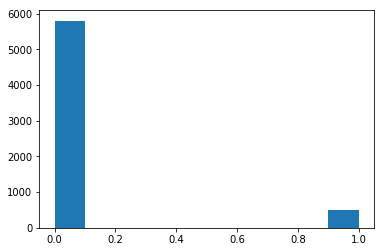

In [63]:
# Check class distribution
plt.hist(label)

## Baseline

The baseline case to compare against

             precision    recall  f1-score   support

          0       0.99      0.94      0.96      1827
          1       0.29      0.65      0.40        66

avg / total       0.96      0.93      0.94      1893



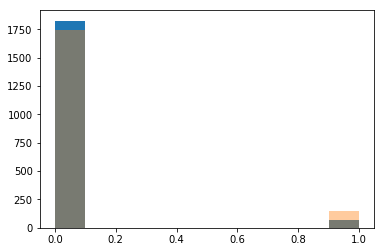

In [64]:
# Assign variables
X = df_lm_new.values
y = label

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

# Classifier
clf = RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.4627239625369487

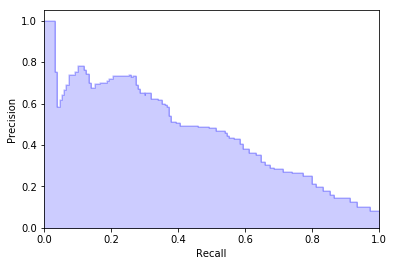

In [65]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])

## Feature selection

Here we are using the python toolbox boruta_py


In [66]:
from boruta import BorutaPy

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	66
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	66
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	66
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	66
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	66
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	66
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	66
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	30
Tentative: 	8
Rejected: 	28


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	30
Tentative: 	8
Rejected: 	28


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	30
Tentative: 	8
Rejected: 	28


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	30
Tentative: 	8
Rejected: 	28


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	31
Tentative: 	7
Rejected: 	28


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	31
Tentative: 	7
Rejected: 	28


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	31
Tentative: 	6
Rejected: 	29


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	31
Tentative: 	6
Rejected: 	29


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	31
Tentative: 	6
Rejected: 	29


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	31
Tentative: 	5
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	31
Tentative: 	5
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	32
Tentative: 	4
Rejected: 	30


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31
Iteration: 	99 / 100
Confirmed: 	32
Tentative: 	3
Rejected: 	31


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	32
Tentative: 	1
Rejected: 	31


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=167, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7fd9694611f8>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7fd9694611f8>,
     two_step=True, verbose=2)

In [67]:
# Print the columns that were found to be important
print(df_lm_new.columns[feat_selector.support_])

# Get the rank
print(pd.DataFrame({'name':df_lm_new.columns,'rank':feat_selector.ranking_}).sort_values('rank'))

# Transform X
X_filtered = feat_selector.transform(X)


Index(['grp_add_assig_0', 'grp_add_assig_1', 'grp_add_assig_tot_0',
       'grp_add_assig_tot_1', 'grp_add_user_0', 'grp_add_user_tot_0',
       'grp_add_user_tot_1', 'grp_added_0', 'grp_added_1', 'q_lvl_0_0',
       'q_lvl_0_1', 'q_lvl_0_cor_0', 'q_lvl_0_cor_1', 'tch_add_assig_0',
       'tch_add_assig_1', 'tch_add_assig_tot_0', 'tch_add_assig_tot_1',
       'tch_add_user_0', 'tch_add_user_1', 'tch_add_user_tot_0',
       'tch_add_user_tot_1', 'tch_added_0', 'tch_attempt_0', 'tch_attempt_1',
       'tch_attempt_tot_0', 'tch_attempt_tot_1', 'tch_create_group_tot_0',
       'tch_create_group_tot_1', 'tch_view_assig_prog_0',
       'tch_view_assig_prog_1', 'tch_view_assig_prog_tot_0',
       'tch_view_assig_prog_tot_1'],
      dtype='object')
                         name  rank
0             grp_add_assig_0     1
42        tch_add_assig_tot_0     1
43        tch_add_assig_tot_1     1
44             tch_add_user_0     1
45             tch_add_user_1     1
46         tch_add_user_tot_0    

             precision    recall  f1-score   support

          0       0.98      0.94      0.96      1817
          1       0.32      0.63      0.42        76

avg / total       0.96      0.93      0.94      1893



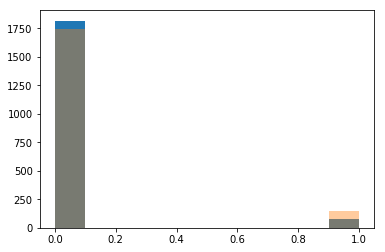

In [68]:
# Let's train and evaluate the model

# Assign
X = X_filtered

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X_filtered)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

# Classifier
clf = RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.44920860633508136

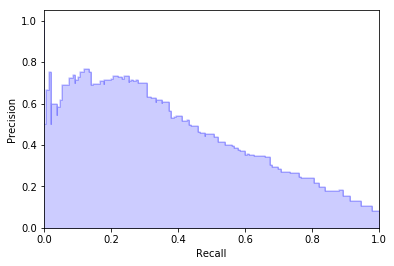

In [69]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])


# Using autoencoders

Here we try to do feature selection using autoencoders. 